In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import FlatLambdaCDM
from mcmc_tools import doMCMC, dolinmix, dolinmix_sep, split_data, plotFit, plotFit_sep, plot_splitdata

rcp_orig = dict(matplotlib.rcParams)

In [2]:
# master = pd.read_csv('data/master_v3.csv')
master = pd.read_csv('data/master_v3.1.csv')
# Removing any object with no vel, categorical or otherwise
master = master[~np.isnan(master.vel)]

In [3]:
c = 299792.458
cosmo = FlatLambdaCDM(H0=70.5, Om0=0.3, Tcmb0=2.725)
mu = lambda z: 5.0*np.log10(Distance(z=z, unit=u.pc, cosmology=cosmo).value) - 5.0
mVcalc = lambda MV, z: MV + mu(z)
mV_cep = lambda MV, mu: MV + mu

def pecvelerr(z, pecvelun=300.0):
    pecvelerr = 5.0/np.log(10) * pecvelun/(c*z)
    return pecvelerr
    
mb = lambda x0: -2.5 * np.log10(x0) + 10.635
mberr = lambda x0, x0err: 2.5 * (x0err / x0) / np.log(10)

# SALT 2 alpha = 0.14
def shpcor(x0, z, x1, alpha=0.14):
    return mb(x0) - mu(z) + alpha*x1
def shpcorerr( x0, x0err, x1err, z, alpha=0.14):
    return np.sqrt(mberr(x0, x0err)**2.0 + (alpha*x1err)**2.0 + pecvelerr(z)**2.0)

In [4]:
wang09_cosmo = master[master.w09 == True][['Name','z','vel','vel_err','c_sncosmo','c_err_sncosmo','x0_sncosmo',
                                           'x0_err_sncosmo','x1_sncosmo','x1_err_sncosmo']]
wang09_ana = master[master.w09 == True][['Name','z','vel','vel_err','c_snana','c_err_snana','x0_snana',
                                         'x0_err_snana','x1_snana','x1_err_snana']]

wang09_cosmo.rename(columns={'c_sncosmo':'c','c_err_sncosmo':'c_err','x0_sncosmo':'x0','x0_err_sncosmo':'x0_err',
                             'x1_sncosmo':'x1','x1_err_sncosmo':'x1_err'},inplace=True)
wang09_ana.rename(columns={'c_snana':'c','c_err_snana':'c_err','x0_snana':'x0','x0_err_snana':'x0_err',
                           'x1_snana':'x1','x1_err_snana':'x1_err'},inplace=True)

wang09_cosmo.replace(to_replace='SN',value='',regex=True,inplace=True)
wang09_ana.replace(to_replace='SN',value='',regex=True,inplace=True)

wang09_cosmo['mb'] = mb(wang09_cosmo['x0'])
wang09_cosmo['mb_err'] = mberr(wang09_cosmo['x0'], wang09_cosmo['x0_err'])

wang09_ana['mb'] = mb(wang09_ana['x0'])
wang09_ana['mb_err'] = mberr(wang09_ana['x0'], wang09_ana['x0_err'])

wang09_cosmo = wang09_cosmo[np.abs(wang09_cosmo['x1']) < 3.0]
wang09_cosmo = wang09_cosmo[wang09_cosmo['x1_err'] < 0.5]
wang09_cosmo = wang09_cosmo[np.abs(wang09_cosmo['c']) < 0.3]
wang09_cosmo = wang09_cosmo[wang09_cosmo['c_err'] < 0.1]
wang09_cosmo = wang09_cosmo[wang09_cosmo['mb_err'] < 0.3]
wang09_ana = wang09_ana[np.abs(wang09_ana['x1']) < 3.0]
wang09_ana = wang09_ana[wang09_ana['x1_err'] < 0.5]
wang09_ana = wang09_ana[np.abs(wang09_ana['c']) < 0.3]
wang09_ana = wang09_ana[wang09_ana['c_err'] < 0.1]
wang09_ana = wang09_ana[wang09_ana['mb_err'] < 0.3]

In [5]:
wang09_cosmo['shp_cor'] = shpcor(wang09_cosmo['x0'], wang09_cosmo['z'], wang09_cosmo['x1'])
wang09_cosmo['shp_cor_a12'] = shpcor(wang09_cosmo['x0'], wang09_cosmo['z'], wang09_cosmo['x1'], alpha=0.12)
wang09_cosmo['shp_cor_a16'] = shpcor(wang09_cosmo['x0'], wang09_cosmo['z'], wang09_cosmo['x1'], alpha=0.16)
wang09_cosmo['shp_cor_a10'] = shpcor(wang09_cosmo['x0'], wang09_cosmo['z'], wang09_cosmo['x1'], alpha=0.10)

wang09_cosmo['shp_cor_err'] = shpcorerr(wang09_cosmo['x0'], wang09_cosmo['x0_err'], wang09_cosmo['x1_err'], 
                                        wang09_cosmo['z'])
wang09_cosmo['shp_cor_err_a12'] = shpcorerr(wang09_cosmo['x0'], wang09_cosmo['x0_err'], wang09_cosmo['x1_err'], 
                                            wang09_cosmo['z'],alpha=0.12)
wang09_cosmo['shp_cor_err_a16'] = shpcorerr(wang09_cosmo['x0'], wang09_cosmo['x0_err'], wang09_cosmo['x1_err'], 
                                            wang09_cosmo['z'],alpha=0.16)
wang09_cosmo['shp_cor_err_a10'] = shpcorerr(wang09_cosmo['x0'], wang09_cosmo['x0_err'], wang09_cosmo['x1_err'], 
                                            wang09_cosmo['z'],alpha=0.10)

In [6]:
wang09_ana['shp_cor'] = shpcor(wang09_ana['x0'], wang09_ana['z'], wang09_ana['x1'])
wang09_ana['shp_cor_a12'] = shpcor(wang09_ana['x0'], wang09_ana['z'], wang09_ana['x1'], alpha=0.12)
wang09_ana['shp_cor_a16'] = shpcor(wang09_ana['x0'], wang09_ana['z'], wang09_ana['x1'], alpha=0.16)
wang09_ana['shp_cor_a10'] = shpcor(wang09_ana['x0'], wang09_ana['z'], wang09_ana['x1'], alpha=0.10)

wang09_ana['shp_cor_err'] = shpcorerr(wang09_ana['x0'], wang09_ana['x0_err'], wang09_ana['x1_err'], 
                                      wang09_ana['z'])
wang09_ana['shp_cor_err_a12'] = shpcorerr(wang09_ana['x0'], wang09_ana['x0_err'], wang09_ana['x1_err'], 
                                            wang09_ana['z'],alpha=0.12)
wang09_ana['shp_cor_err_a16'] = shpcorerr(wang09_ana['x0'], wang09_ana['x0_err'], wang09_ana['x1_err'], 
                                            wang09_ana['z'],alpha=0.16)
wang09_ana['shp_cor_err_a10'] = shpcorerr(wang09_ana['x0'], wang09_ana['x0_err'], wang09_ana['x1_err'], 
                                            wang09_ana['z'],alpha=0.10)

There is an offset in the zeropoints between the SNANA fits and the sncosmo fits. Since the sncosmo zeropoint more closely resembles the fits from W09, we will shift the overall $m_B$ values (and thus the shape corrected magnitude) of the SNANA fits by the difference of their means

In [7]:
mean_diff_mb = np.mean(wang09_cosmo['mb']) - np.mean(wang09_ana['mb'])
mean_diff_shpcr = np.mean(wang09_cosmo['shp_cor']) - np.mean(wang09_ana['shp_cor'])

wang09_ana['mb'] = wang09_ana['mb'] + mean_diff_mb
wang09_ana['shp_cor'] = wang09_ana['shp_cor'] + mean_diff_shpcr

In [8]:
wang09 = pd.read_csv('data/Wang2009_v2.txt', delim_whitespace=True, comment='#',
                    names=['Name','cz','MV','MV_err','dm15','dm15_err','B-V','B-V_err',
                          'E(B-V)','E(B-V)_err','Type'])
wang09.head()

Name    cz     MV  MV_err  dm15  dm15_err   B-V  B-V_err  E(B-V)  \
0   1989B   549 -18.15    0.15  1.35      0.05  0.32     0.07    0.39   
1   1990N  1179 -19.09    0.14  1.05      0.05  0.00     0.05    0.11   
2  1994ae  1575 -19.35    0.15  0.89      0.05 -0.05     0.05    0.04   
3   1994D  1179 -19.26    0.57  1.31      0.05 -0.08     0.05   -0.04   
4   1995D  2129 -19.18    0.31  1.02      0.05 -0.02     0.05    0.09   

   E(B-V)_err Type  
0        0.05    N  
1        0.04    N  
2        0.04    N  
3        0.04    N  
4        0.04    N

In [9]:
# burns18 = pd.read_csv('data/Burns2018_SNinfo.txt', delim_whitespace=True, comment='#',
#                       names=['Name','zhel','zcmb','sBV','sBV_err','dm15','dm15_err','Vmax','Vmax_err','E(B-V)',
#                              'E(B-V)_err','Rv','Rv_err','cov','mu','mu_err','q'])
# burns18['Name'] = burns18['Name'].str.lower()
# burns18.head()

Updating W09 data with newer measurements from Burns et al. 2018, uncomment if you want the updated values.

In [10]:
# for i in wang09.index:
#     name_w09 = wang09.loc[i,'Name'].lower()
#     if name_w09 in burns18.Name.values:
#         wang09.loc[i,'E(B-V)'] = burns18.loc[burns18.Name == name_w09,'E(B-V)'].values[0]
#         wang09.loc[i,'E(B-V)_err'] = burns18.loc[burns18.Name == name_w09,'E(B-V)_err'].values[0]
#         wang09.loc[i,'dm15'] = burns18.loc[burns18.Name == name_w09,'dm15'].values[0]
#         wang09.loc[i,'dm15_err'] = burns18.loc[burns18.Name == name_w09,'dm15_err'].values[0]
#         wang09.loc[i,'MV'] = (burns18.loc[burns18.Name == name_w09,'Vmax'].values[0]-
#                               burns18.loc[burns18.Name == name_w09,'mu'].values[0])
    
# wang09.head()

In [11]:
wang09['z'] = wang09['cz']/c
wang09['shp_cor'] = wang09['MV'] - 0.75*(wang09['dm15'] - 1.1)
wang09['shp_cor_err'] = wang09['MV_err'] + (0.75*wang09['dm15_err'])**2

cepheids = {'Name':['1990N','1994ae','1998aq','1981B'], 
            'mu':[31.73,32.29,31.66,30.88]}

wang09['mV'] = mVcalc(wang09['MV'], wang09['z'])
wang09.loc[np.isin(wang09['Name'], cepheids['Name']), 'mu'] = cepheids['mu']
wang09.loc[np.isin(wang09['Name'], cepheids['Name']), 'mV'] = \
mV_cep(wang09.loc[np.isin(wang09['Name'], cepheids['Name']), 'MV'], 
       wang09.loc[np.isin(wang09['Name'], cepheids['Name']), 'mu'])

In [12]:
# objects not included in W09 fit
excluded = ['2006lf', '2001el', '1996ai', '2003cg', '1999cl', '2003hx', '2002bo', '2007le',
            '1997dt', '1998dm', '1994D', '1995D', '1996X', '2001bg', '2002er', '2002fk', 
            '2003du', '2003hv', '2003kf', '2005am', '2005cf', '2006D', '2007af', '2007bm', 
            '1983G', '1984A', '1989A', '1992A', '1997bp', '1998dh', '2002dj', '2003hx', 
            '2007gi', '2007le', '2007sr', '2006bt', '2004bd', '2004S']

wang09_cut = wang09[~np.isin(wang09['Name'], excluded)].copy()
# We will also get rid of the cepheid host SNe
wang09_cut = wang09[~np.isin(wang09['Name'], cepheids['Name'])].copy()
print(len(wang09_cut.Name))
wang09_cut = wang09_cut[wang09_cut['E(B-V)'] < 0.35]
print(len(wang09_cut.Name))
print(len(wang09.Name))
print(len(wang09_cut.Name))

154
121
158
121


W09 data does not include velocity information, so for the purposes of this notebook we will set the 'Normal' (low-velocity) objects to have a velocity = -10,000 km/s and the 'High Velocity' objects to -12,000 km/s

In [14]:
wang09_cut['vel'] = np.empty(len(wang09_cut.Name))
wang09_cut.loc[wang09_cut.Type == 'N', 'vel'] = -10.0
wang09_cut.loc[wang09_cut.Type != 'N', 'vel'] = -12.0

Making a subset of the sncosmo and snana fits that exclude the objects from the "excluded" list as well as making a subset of all datasets that only include the objects common between all of them.

In [15]:
wang09_cosmo_uv = wang09_cosmo.copy(deep=True)
wang09_ana_uv = wang09_ana.copy(deep=True)
wang09_cut_uv = wang09_cut.copy(deep=True)

In [16]:
for i in wang09_cosmo.index:
    name_cosmo = wang09_cosmo.loc[i,'Name'].lower()
    for j in wang09_cut.index:
        name_w09 = wang09_cut.loc[j,'Name'].lower()
        if name_cosmo == name_w09:
            wang09_cosmo.loc[i,'vel'] = wang09_cut.loc[j,'vel']
            
wang09_cosmo_cut = wang09_cosmo[~np.isin(wang09_cosmo['Name'], excluded)].copy()

In [17]:
for i in wang09_ana.index:
    name_ana = wang09_ana.loc[i,'Name'].lower()
    for j in wang09_cut.index:
        name_w09 = wang09_cut.loc[j,'Name'].lower()
        if name_ana == name_w09:
            wang09_ana.loc[i,'vel'] = wang09_cut.loc[j,'vel']
            
wang09_ana_cut = wang09_ana[~np.isin(wang09_ana['Name'], excluded)].copy()

In [18]:
# making a different set of dataframes with my velocities rather than W09's original velocities
for i in wang09_cosmo_uv.index:
    name_cosmo = wang09_cosmo_uv.loc[i,'Name'].lower()
    for j in wang09_cut.index:
        name_w09 = wang09_cut.loc[j,'Name'].lower()
        if name_cosmo == name_w09:
            if (wang09_cut_uv.loc[j,'vel'] < -11.8) & (wang09_cosmo_uv.loc[i,'vel'] > -11.8):
                print('{} switched from HV to NV'.format(name_cosmo))
            elif (wang09_cut_uv.loc[j,'vel'] > -11.8) & (wang09_cosmo_uv.loc[i,'vel'] < -11.8):
                print('{} switched from NV to HV'.format(name_cosmo))
            wang09_cut_uv.loc[j,'vel'] = wang09_cosmo_uv.loc[i,'vel']
            
wang09_cosmo_uv_cut = wang09_cosmo_uv[~np.isin(wang09_cosmo_uv['Name'], excluded)].copy()
wang09_ana_uv_cut = wang09_ana_uv[~np.isin(wang09_ana_uv['Name'], excluded)].copy()

2005am switched from NV to HV
2006ej switched from HV to NV
2002de switched from HV to NV
2001bg switched from NV to HV
2000fa switched from HV to NV
2006le switched from HV to NV
2004as switched from HV to NV
1997e switched from NV to HV
2006gr switched from HV to NV
2002he switched from NV to HV
2007co switched from HV to NV
2003cq switched from HV to NV


In [19]:
wang09_scut = wang09_cut[np.isin(wang09_cut['Name'].str.lower(), wang09_cosmo_cut['Name'].str.lower())].copy()
wang09_scut = wang09_scut[np.isin(wang09_scut['Name'].str.lower(), wang09_ana_cut['Name'].str.lower())].copy()
wang09_cosmo_scut = wang09_cosmo_cut[np.isin(wang09_cosmo_cut['Name'].str.lower(),
                                             wang09_scut['Name'].str.lower())].copy()
wang09_cosmo_scut = wang09_cosmo_scut[np.isin(wang09_cosmo_scut['Name'].str.lower(),
                                              wang09_ana_cut['Name'].str.lower())].copy()
wang09_ana_scut = wang09_ana_cut[np.isin(wang09_ana_cut['Name'].str.lower(),
                                         wang09_scut['Name'].str.lower())].copy()
wang09_ana_scut = wang09_ana_scut[np.isin(wang09_ana_scut['Name'].str.lower(),
                                          wang09_cosmo_scut['Name'].str.lower())].copy()

print(len(wang09_scut))
print(len(wang09_cosmo_scut))
print(len(wang09_ana_scut))

88
88
88


In [20]:
wang09_uv_scut = wang09_cut_uv[np.isin(wang09_cut_uv['Name'].str.lower(), wang09_cosmo_uv_cut['Name'].str.lower())].copy()
wang09_uv_scut = wang09_uv_scut[np.isin(wang09_scut['Name'].str.lower(), wang09_ana_uv_cut['Name'].str.lower())].copy()
wang09_cosmo_uv_scut = wang09_cosmo_uv_cut[np.isin(wang09_cosmo_uv_cut['Name'].str.lower(),
                                             wang09_scut['Name'].str.lower())].copy()
wang09_cosmo_uv_scut = wang09_cosmo_uv_scut[np.isin(wang09_cosmo_scut['Name'].str.lower(),
                                              wang09_ana_uv_cut['Name'].str.lower())].copy()
wang09_ana_uv_scut = wang09_ana_uv_cut[np.isin(wang09_ana_uv_cut['Name'].str.lower(),
                                         wang09_scut['Name'].str.lower())].copy()
wang09_ana_uv_scut = wang09_ana_uv_scut[np.isin(wang09_ana_scut['Name'].str.lower(),
                                          wang09_cosmo_scut['Name'].str.lower())].copy()

print(len(wang09_uv_scut))
print(len(wang09_cosmo_uv_scut))
print(len(wang09_ana_uv_scut))

88
88
88


In [21]:
wang09_ana_scut['Name'].to_csv('data/w09CompName.txt', header='Name')

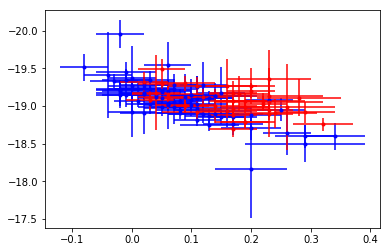

In [22]:
wang09_cut['x'] = wang09_cut['E(B-V)']
wang09_cut['xerr'] = wang09_cut['E(B-V)_err']
wang09_cut['y'] = wang09_cut['shp_cor']
wang09_cut['yerr'] = wang09_cut['shp_cor_err']
splitdata_w09 = split_data(wang09_cut)
plot_splitdata(splitdata_w09)

N_low = 61, N_high = 27


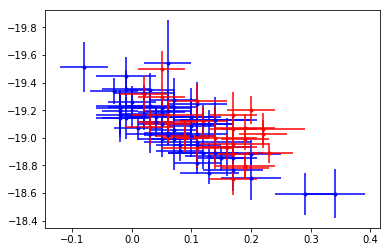

In [23]:
wang09_scut['x'] = wang09_scut['E(B-V)']
wang09_scut['xerr'] = wang09_scut['E(B-V)_err']
wang09_scut['y'] = wang09_scut['shp_cor']
wang09_scut['yerr'] = wang09_scut['shp_cor_err']
splitdata_w09s = split_data(wang09_scut)
print('N_low = {}, N_high = {}'.format(splitdata_w09s['n_lv'], splitdata_w09s['n_hv']))
plot_splitdata(splitdata_w09s)

In [24]:
wang09_scut[wang09_scut.shp_cor > -18.25]

Empty DataFrame
Columns: [Name, cz, MV, MV_err, dm15, dm15_err, B-V, B-V_err, E(B-V), E(B-V)_err, Type, z, shp_cor, shp_cor_err, mV, mu, vel, x, xerr, y, yerr]
Index: []

[0 rows x 21 columns]

N_low = 67, N_high = 21


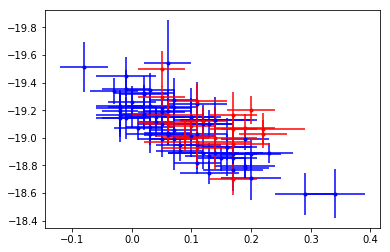

In [25]:
wang09_uv_scut['x'] = wang09_uv_scut['E(B-V)']
wang09_uv_scut['xerr'] = wang09_uv_scut['E(B-V)_err']
wang09_uv_scut['y'] = wang09_uv_scut['shp_cor']
wang09_uv_scut['yerr'] = wang09_uv_scut['shp_cor_err']
splitdata_w09suv = split_data(wang09_uv_scut)
print('N_low = {}, N_high = {}'.format(splitdata_w09suv['n_lv'], splitdata_w09suv['n_hv']))
plot_splitdata(splitdata_w09suv)

N_low = 61, N_high = 27


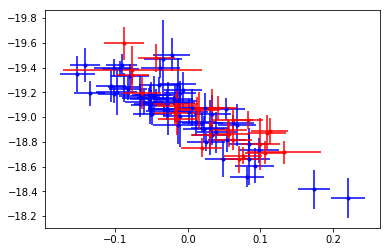

In [26]:
wang09_cosmo_scut['x'] = wang09_cosmo_scut['c']
wang09_cosmo_scut['xerr'] = wang09_cosmo_scut['c_err']
wang09_cosmo_scut['y'] = wang09_cosmo_scut['shp_cor']
wang09_cosmo_scut['yerr'] = wang09_cosmo_scut['shp_cor_err']
splitdata_w09s_cosmo = split_data(wang09_cosmo_scut)
print('N_low = {}, N_high = {}'.format(splitdata_w09s_cosmo['n_lv'], splitdata_w09s_cosmo['n_hv']))
plot_splitdata(splitdata_w09s_cosmo)

N_low = 67, N_high = 21


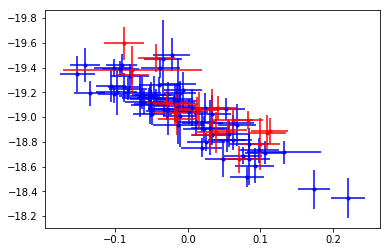

In [27]:
wang09_cosmo_uv_scut['x'] = wang09_cosmo_uv_scut['c']
wang09_cosmo_uv_scut['xerr'] = wang09_cosmo_uv_scut['c_err']
wang09_cosmo_uv_scut['y'] = wang09_cosmo_uv_scut['shp_cor']
wang09_cosmo_uv_scut['yerr'] = wang09_cosmo_uv_scut['shp_cor_err']
splitdata_w09suv_cosmo = split_data(wang09_cosmo_uv_scut)
print('N_low = {}, N_high = {}'.format(splitdata_w09suv_cosmo['n_lv'], splitdata_w09suv_cosmo['n_hv']))
plot_splitdata(splitdata_w09suv_cosmo)

In [28]:
print(len(wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel < -11.8]))
print(len(wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel > -11.8]))

print(len(wang09_cosmo_scut[wang09_cosmo_scut.vel < -11.8]))
print(len(wang09_cosmo_scut[wang09_cosmo_scut.vel > -11.8]))

21
67
27
61


In [29]:
for i in wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel < -11.8].index:
    if wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel < -11.8].loc[i,'Name'] not in wang09_cosmo_scut[wang09_cosmo_scut.vel < -11.8].Name.values:
        print('{} in new HV sample, not in old HV sample'.format(wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel < -11.8].loc[i,'Name']))

1997e in new HV sample, not in old HV sample
2002he in new HV sample, not in old HV sample


In [30]:
for i in wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel > -11.8].index:
    if wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel > -11.8].loc[i,'Name'] not in wang09_cosmo_scut[wang09_cosmo_scut.vel > -11.8].Name.values:
        print('{} in new NV sample, not in old NV sample'.format(wang09_cosmo_uv_scut[wang09_cosmo_uv_scut.vel > -11.8].loc[i,'Name']))

2006ej in new NV sample, not in old NV sample
2002de in new NV sample, not in old NV sample
2000fa in new NV sample, not in old NV sample
2006le in new NV sample, not in old NV sample
2004as in new NV sample, not in old NV sample
2006gr in new NV sample, not in old NV sample
2007co in new NV sample, not in old NV sample
2003cq in new NV sample, not in old NV sample


In [31]:
print(wang09_cosmo_scut[wang09_cosmo_scut.vel > -11.8][['Name','vel']].sort_values('Name'))

       Name   vel
215   1996x -10.0
227   1997e -10.0
243  1998eg -10.0
199  1999cp -10.0
257  1999ej -10.0
250  2000cf -10.0
263  2000cn -10.0
287  2000cw -10.0
239  2000dk -10.0
292  2000dm -10.0
286  2000dn -10.0
288  2000dr -10.0
294  2001bf -10.0
254  2001cj -10.0
249  2001ck -10.0
274  2001cp -10.0
228  2001ep -10.0
226  2001fe -10.0
251  2001fh -10.0
217  2002aw -10.0
264  2002cr -10.0
205  2002dp -10.0
295  2002eb -10.0
266  2002el -10.0
200  2002ha -10.0
259  2002he -10.0
219  2002hu -10.0
246  2003gt -10.0
224  2003he -10.0
277  2004at -10.0
..      ...   ...
2    2004eo -10.0
3    2004ey -10.0
269  2004fz -10.0
5    2004gs -10.0
209   2004s -10.0
12   2005bo -10.0
198  2005de -10.0
13   2005el -10.0
14   2005hc -10.0
16   2005iq -10.0
17   2005kc -10.0
18   2005ki -10.0
234  2005lz -10.0
291  2005ms -10.0
22   2005na -10.0
25   2006ax -10.0
265  2006az -10.0
23    2006d -10.0
221  2006dm -10.0
238  2006en -10.0
38   2006kf -10.0
248   2006n -10.0
40   2006ob -10.0
230   2006

In [32]:
wang09_cosmo_scut['y'] = wang09_cosmo_scut['shp_cor_a12']
wang09_cosmo_scut['yerr'] = wang09_cosmo_scut['shp_cor_err_a12']
splitdata_w09s_cosmo_a12 = split_data(wang09_cosmo_scut)

wang09_cosmo_scut['y'] = wang09_cosmo_scut['shp_cor_a12']
wang09_cosmo_scut['yerr'] = wang09_cosmo_scut['shp_cor_err_a16']
splitdata_w09s_cosmo_a16 = split_data(wang09_cosmo_scut)

wang09_cosmo_scut['y'] = wang09_cosmo_scut['shp_cor_a12']
wang09_cosmo_scut['yerr'] = wang09_cosmo_scut['shp_cor_err_a10']
splitdata_w09s_cosmo_a10 = split_data(wang09_cosmo_scut)

N_low = 61, N_high = 27


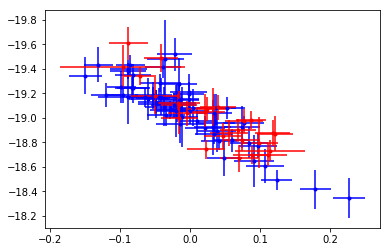

In [33]:
wang09_ana_scut['x'] = wang09_ana_scut['c']
wang09_ana_scut['xerr'] = wang09_ana_scut['c_err']
wang09_ana_scut['y'] = wang09_ana_scut['shp_cor']
wang09_ana_scut['yerr'] = wang09_ana_scut['shp_cor_err']
splitdata_w09s_ana = split_data(wang09_ana_scut)
print('N_low = {}, N_high = {}'.format(splitdata_w09s_ana['n_lv'], splitdata_w09s_ana['n_hv']))
plot_splitdata(splitdata_w09s_ana)

N_low = 67, N_high = 21


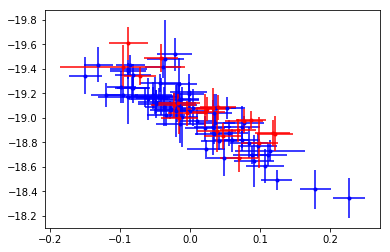

In [34]:
wang09_ana_uv_scut['x'] = wang09_ana_uv_scut['c']
wang09_ana_uv_scut['xerr'] = wang09_ana_uv_scut['c_err']
wang09_ana_uv_scut['y'] = wang09_ana_uv_scut['shp_cor']
wang09_ana_uv_scut['yerr'] = wang09_ana_uv_scut['shp_cor_err']
splitdata_w09suv_ana = split_data(wang09_ana_uv_scut)
print('N_low = {}, N_high = {}'.format(splitdata_w09suv_ana['n_lv'], splitdata_w09suv_ana['n_hv']))
plot_splitdata(splitdata_w09suv_ana)

In [35]:
wang09_ana_scut['y'] = wang09_ana_scut['shp_cor_a12']
wang09_ana_scut['yerr'] = wang09_ana_scut['shp_cor_err_a12']
splitdata_w09s_ana_a12 = split_data(wang09_ana_scut)

wang09_ana_scut['y'] = wang09_ana_scut['shp_cor_a12']
wang09_ana_scut['yerr'] = wang09_ana_scut['shp_cor_err_a16']
splitdata_w09s_ana_a16 = split_data(wang09_ana_scut)

wang09_ana_scut['y'] = wang09_ana_scut['shp_cor_a12']
wang09_ana_scut['yerr'] = wang09_ana_scut['shp_cor_err_a10']
splitdata_w09s_ana_a10 = split_data(wang09_ana_scut)

In [36]:
def doublePlot_wfit(splitdata1, splitdata2, sep1, sep2):

    matplotlib.rcParams["mathtext.fontset"] = "stix"
    matplotlib.rcParams["font.family"] = "STIXGeneral"
    matplotlib.rcParams["lines.linewidth"] = 2
    matplotlib.rcParams["axes.linewidth"] = 1.2
    matplotlib.rcParams["xtick.major.size"] = 8.0
    matplotlib.rcParams["ytick.major.size"] = 8.0
    matplotlib.rcParams["xtick.minor.size"] = 3.0
    matplotlib.rcParams["ytick.minor.size"] = 3.0
    matplotlib.rcParams["xtick.minor.visible"] = True
    matplotlib.rcParams["xtick.direction"] = "in"
    matplotlib.rcParams["ytick.minor.visible"] = True
    matplotlib.rcParams["ytick.direction"] = "in"
    matplotlib.rcParams["xtick.top"] = True
    matplotlib.rcParams["ytick.right"] = True
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, gridspec_kw={"wspace":0.0})
    fig.set_size_inches(fig.get_size_inches()[0]*2.1,fig.get_size_inches()[1])
    
    plotFit_sep(sep1, splitdata1, ax=ax1,xlabel=r'$E(B-V)$ [mag]', ylabel=r'$M_V - 0.75(\Delta m_{15} - 1.1)$ [mag]')
    plotFit_sep(sep2, splitdata2, ax=ax2,xlabel=r'SALT2 $c$', ylabel=r'$m_B + \alpha x_1 - \mu_z$ [mag]', right=True)

    percentiles_sc = np.percentile(sep1, [16,84], axis=0)
    offset_sc = np.median(sep1[:,0])
    offset_sc_unc = np.mean([np.abs(percentiles_sc[:,0][0] - offset_sc), 
                             np.abs(percentiles_sc[:,0][1] - offset_sc)])
    
    slope_sc = np.median(sep1[:,1])
    slope_sc_unc = np.mean([np.abs(percentiles_sc[:,1][0] - slope_sc), 
                            np.abs(percentiles_sc[:,1][1] - slope_sc)])
    ax1.text(-0.15,-18.25, r'color offset = {:.3f} $\pm$ {:.3f} mag'
             .format(offset_sc, offset_sc_unc),
            fontsize=18)
    ax1.text(-0.15,-18.39,r'$R_v$ = {:.2f} $\pm$ {:.2f}'.format(slope_sc,slope_sc_unc),fontsize=16)

    percentiles_w2 = np.percentile(sep2, [16,84], axis=0)
    offset_w2 = np.median(sep2[:,0])
    offset_w2_unc = np.mean([np.abs(percentiles_w2[:,0][0] - offset_w2), 
                             np.abs(percentiles_w2[:,0][1] - offset_w2)])
    
    slope_w2 = np.median(sep2[:,1])
    slope_w2_unc = np.mean([np.abs(percentiles_w2[:,1][0] - slope_w2), 
                            np.abs(percentiles_w2[:,1][1] - slope_w2)])
    ax2.text(-0.18,-18.25, r'color offset = {:.3f} $\pm$ {:.3f}'.format(offset_w2, offset_w2_unc),fontsize=18)
    ax2.text(-0.18,-18.39,r'$\beta$ = {:.2f} $\pm$ {:.2f}'.format(slope_w2,slope_w2_unc),fontsize=16)
    ax1.set_ylim([-18.1,-19.8])
    ax1.set_xlim(-0.2,0.45)
    ax2.set_xlim(-0.22,0.28)
    
    ax1.text(0.22,-19.55, r'$N_\mathrm{high\ velocity} =$' + '{:d}'.format(splitdata1['n_hv']), fontsize=16, color='r')
    ax1.text(0.22,-19.4, r'$N_\mathrm{normal} =$' + '{:d}'.format(splitdata1['n_lv']), fontsize=16, color='b')
    ax2.text(0.1,-19.55, r'$N_\mathrm{high\ velocity} =$' + '{:d}'.format(splitdata2['n_hv']), fontsize=16, color='r')
    ax2.text(0.1,-19.4, r'$N_\mathrm{normal} =$' + '{:d}'.format(splitdata2['n_lv']), fontsize=16, color='b')
    
    ax1.set_xlabel(r'$E(B-V)_{host}$ [mag]',fontsize=20)
    ax1.set_ylabel(r'$M_V - 0.75(\Delta m_{15} - 1.1)$ [mag]',fontsize=20)
    ax1.tick_params(labelsize=16)

sampling slopes...


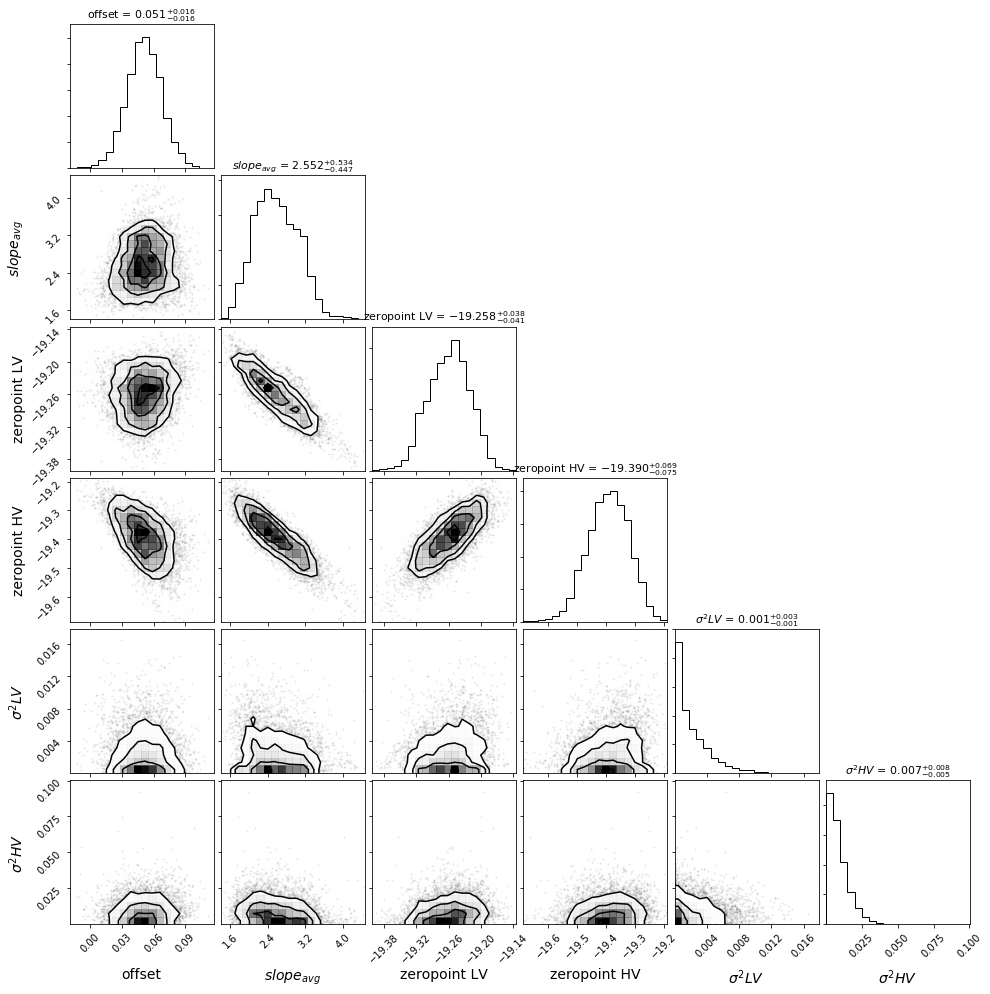

In [37]:
import random
random.seed(1766)

matplotlib.rcParams.update(rcp_orig)
niter = 10000

w09_sep = dolinmix_sep(splitdata_w09s,numiter=niter)

sampling slopes...


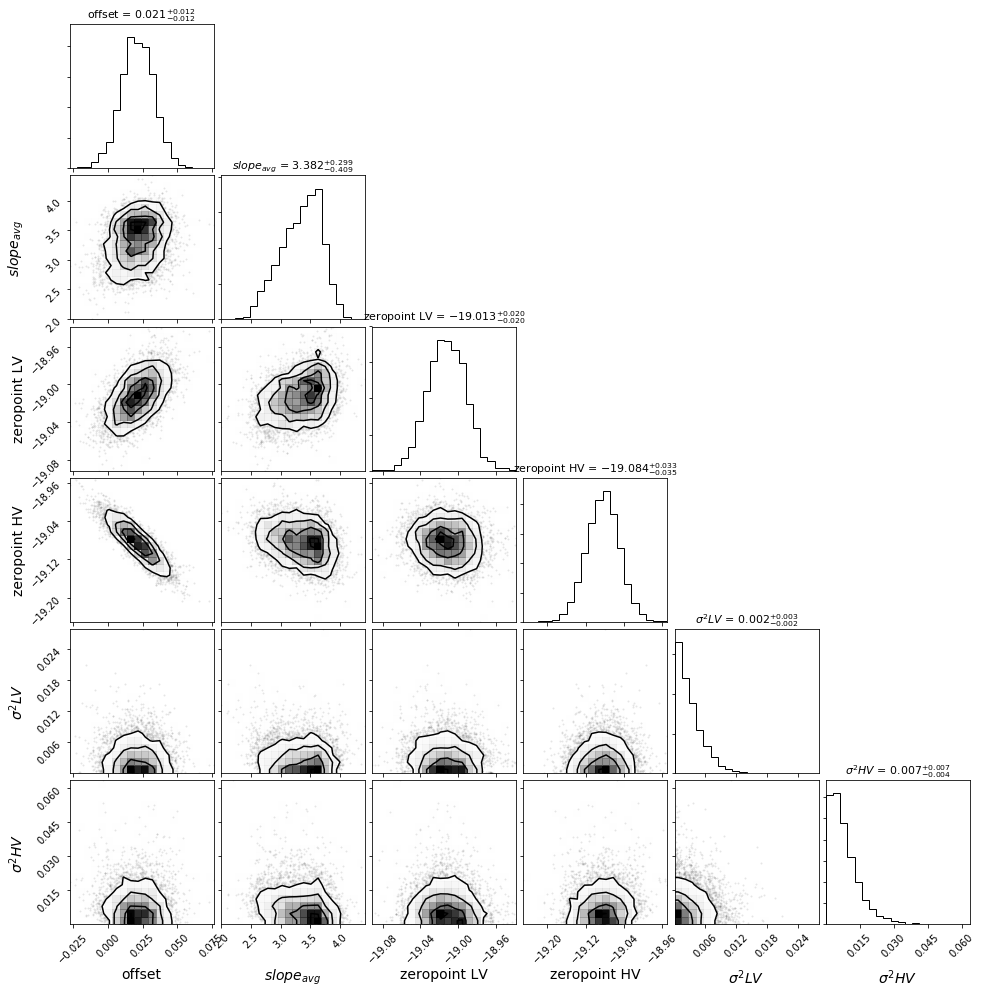

In [38]:
w09_cosmo_sep = dolinmix_sep(splitdata_w09s_cosmo,numiter=niter)

sampling slopes...
sampling slopes...
sampling slopes...


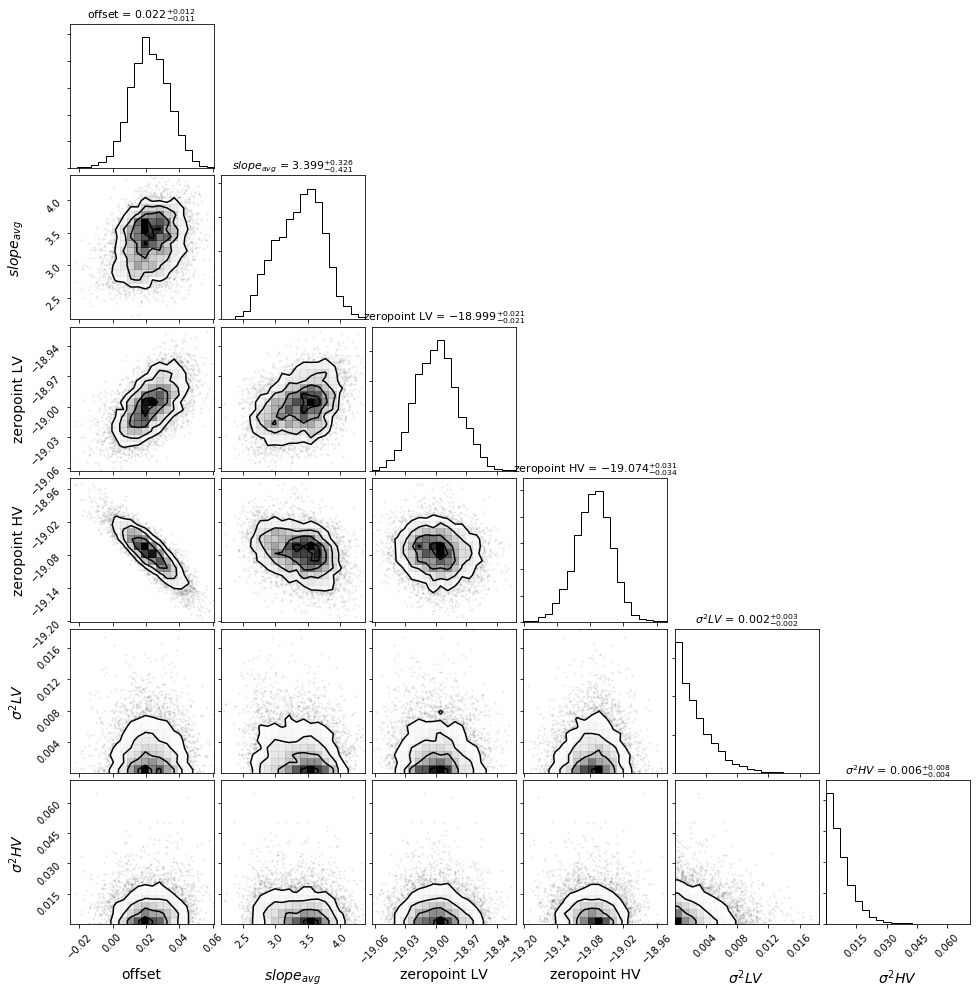

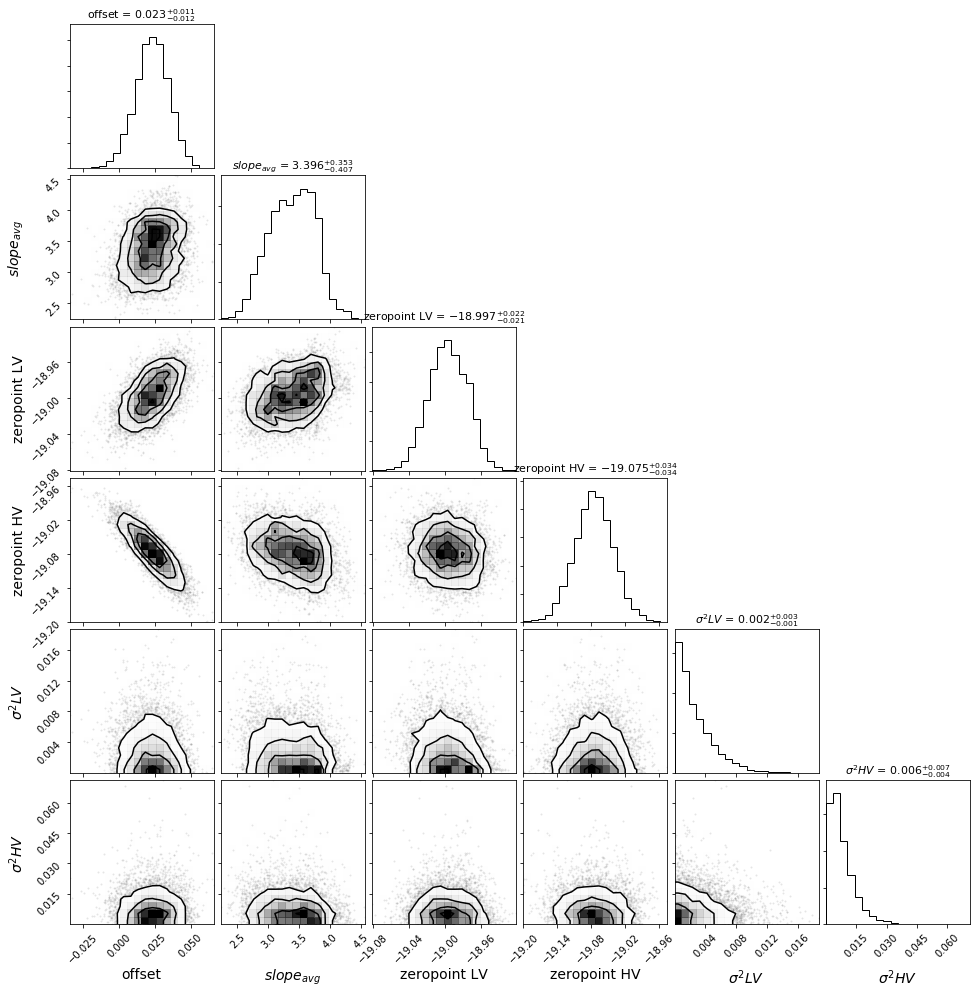

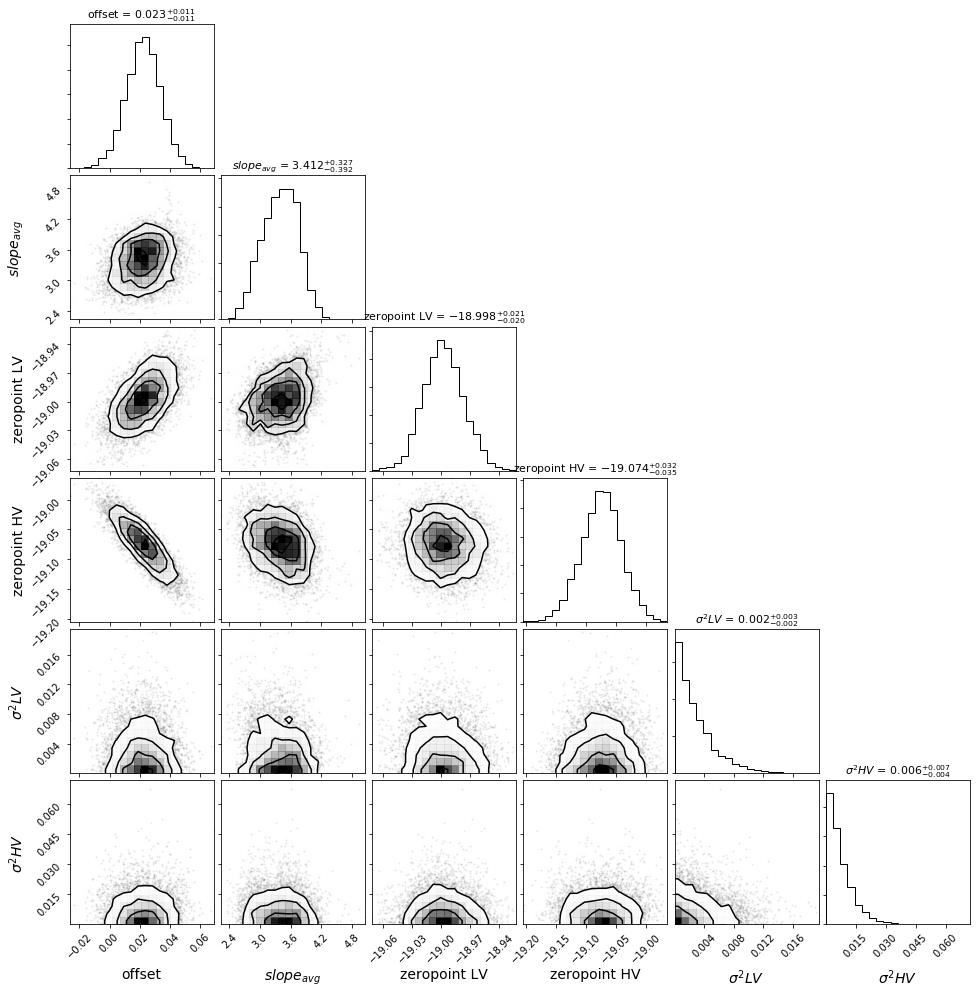

In [39]:
w09_cosmo_sep_a12 = dolinmix_sep(splitdata_w09s_cosmo_a12,numiter=niter)
w09_cosmo_sep_a16 = dolinmix_sep(splitdata_w09s_cosmo_a16,numiter=niter)
w09_cosmo_sep_a10 = dolinmix_sep(splitdata_w09s_cosmo_a10,numiter=niter)

sampling slopes...


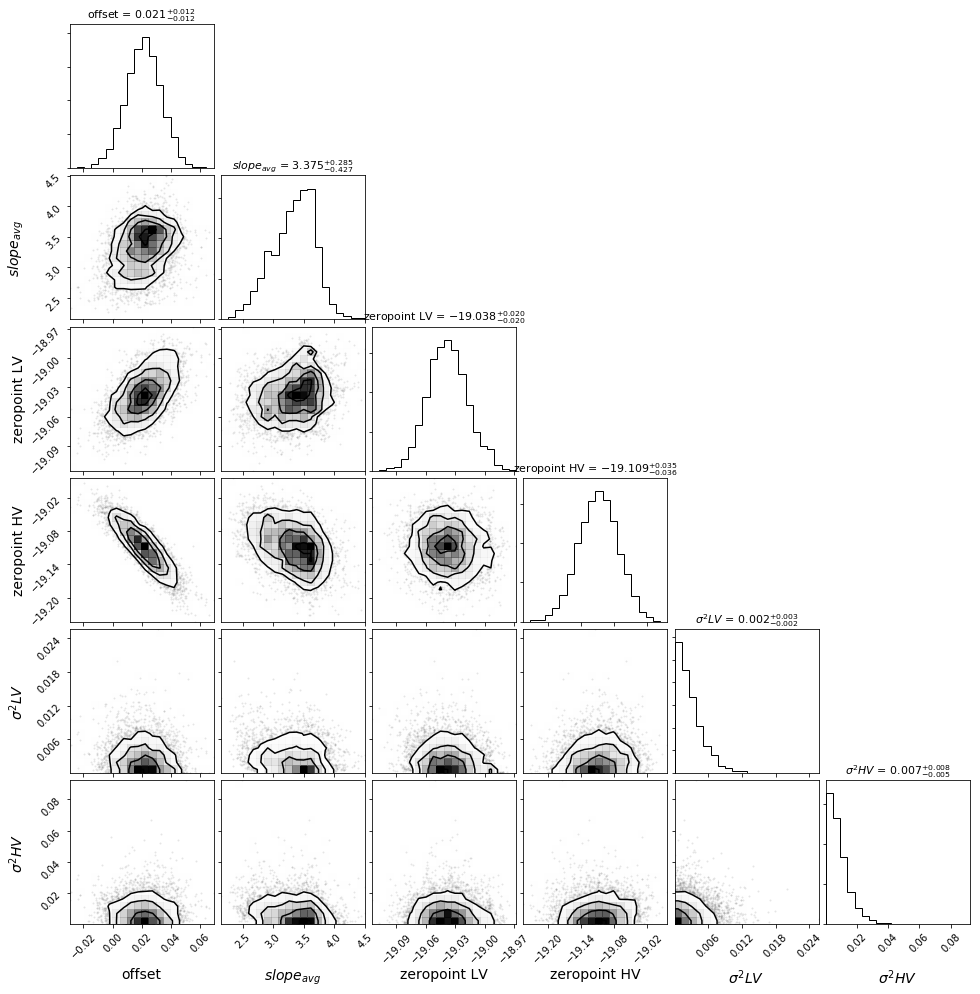

In [40]:
w09_ana_sep = dolinmix_sep(splitdata_w09s_ana,numiter=niter)

sampling slopes...
sampling slopes...
sampling slopes...


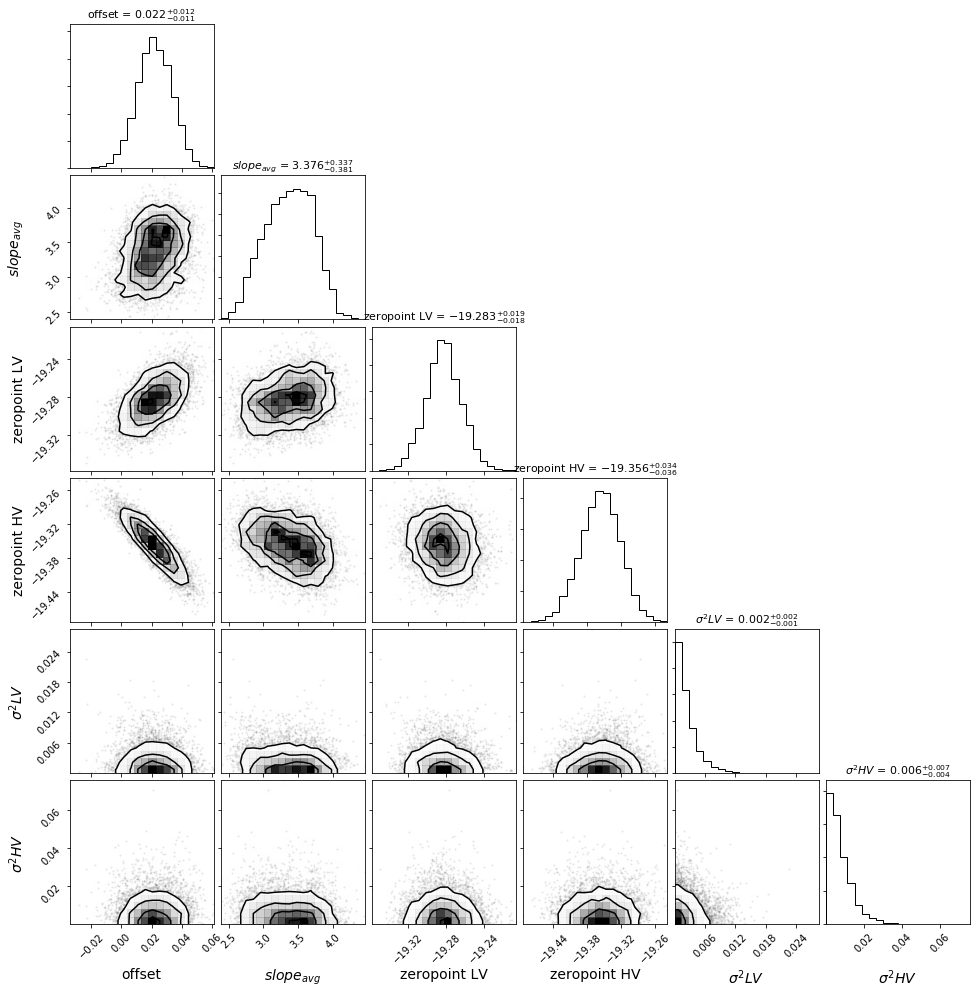

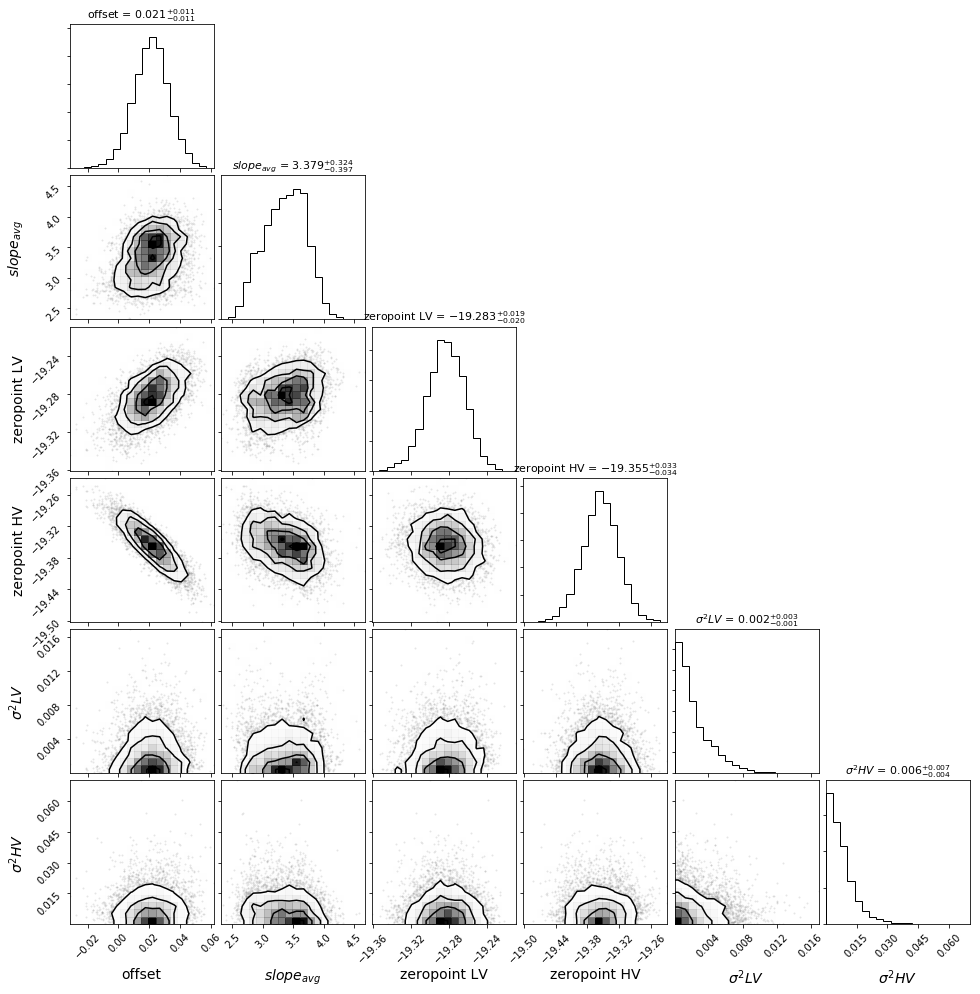

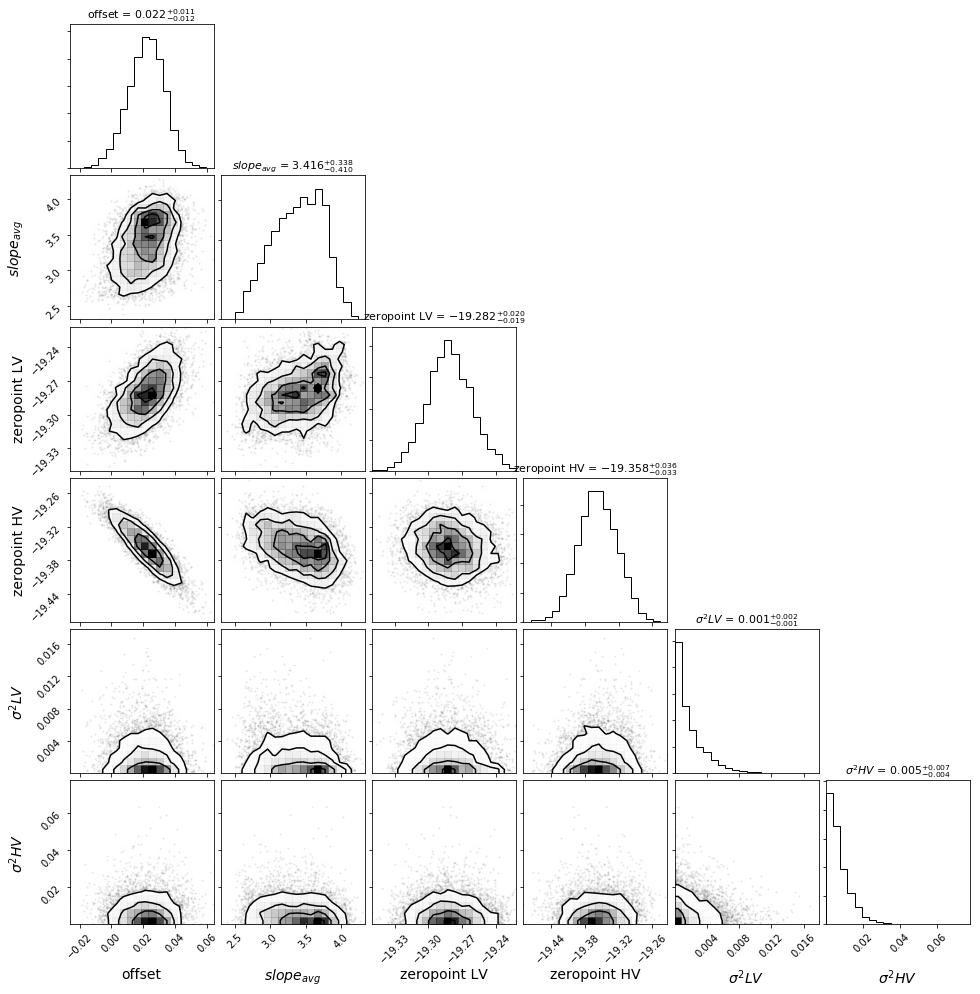

In [41]:
w09_ana_sep_a12 = dolinmix_sep(splitdata_w09s_ana_a12,numiter=niter)
w09_ana_sep_a16 = dolinmix_sep(splitdata_w09s_ana_a16,numiter=niter)
w09_ana_sep_a10 = dolinmix_sep(splitdata_w09s_ana_a10,numiter=niter)

sampling slopes...
sampling slopes...
sampling slopes...


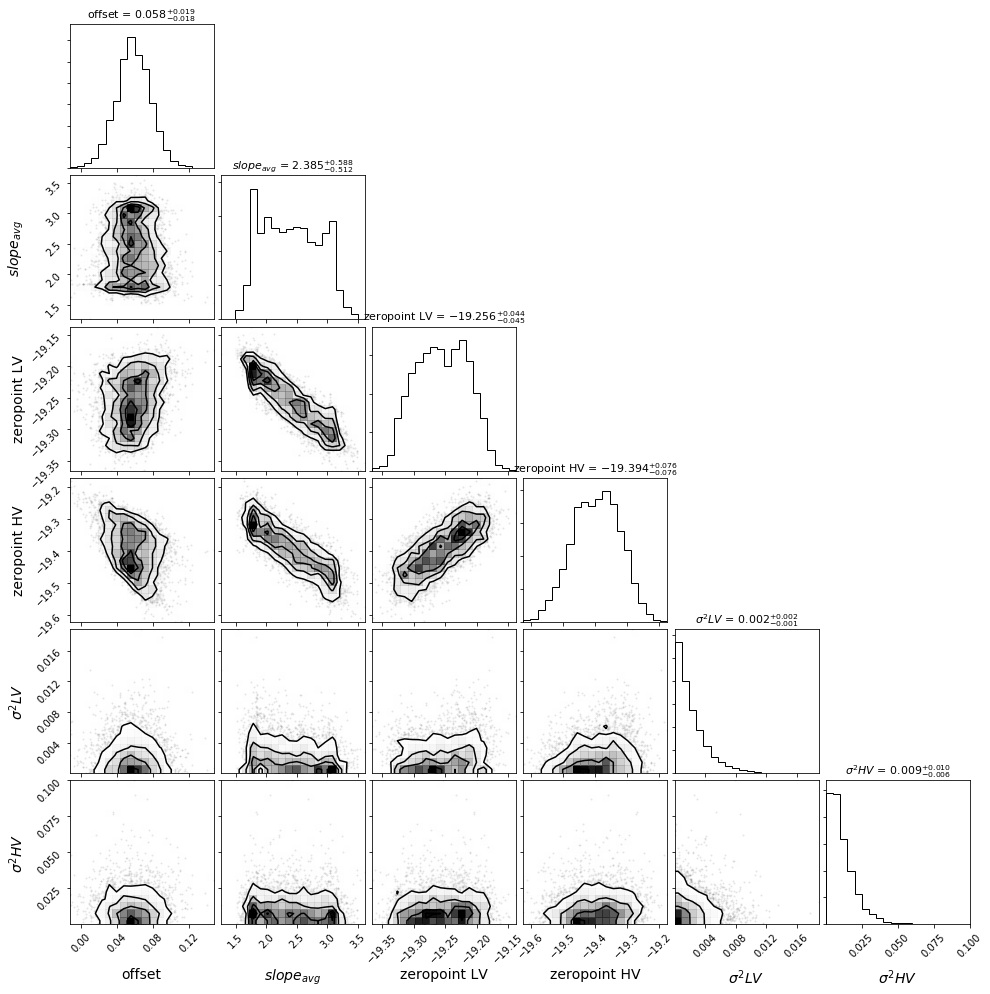

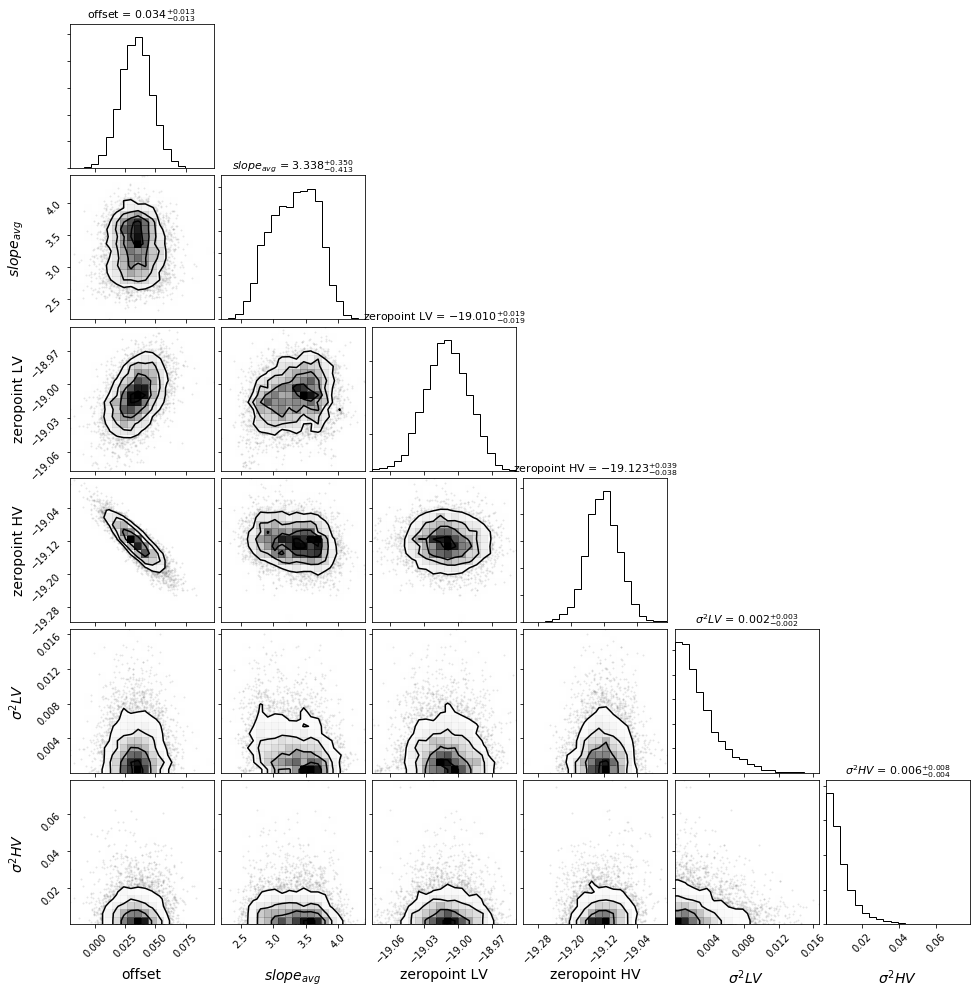

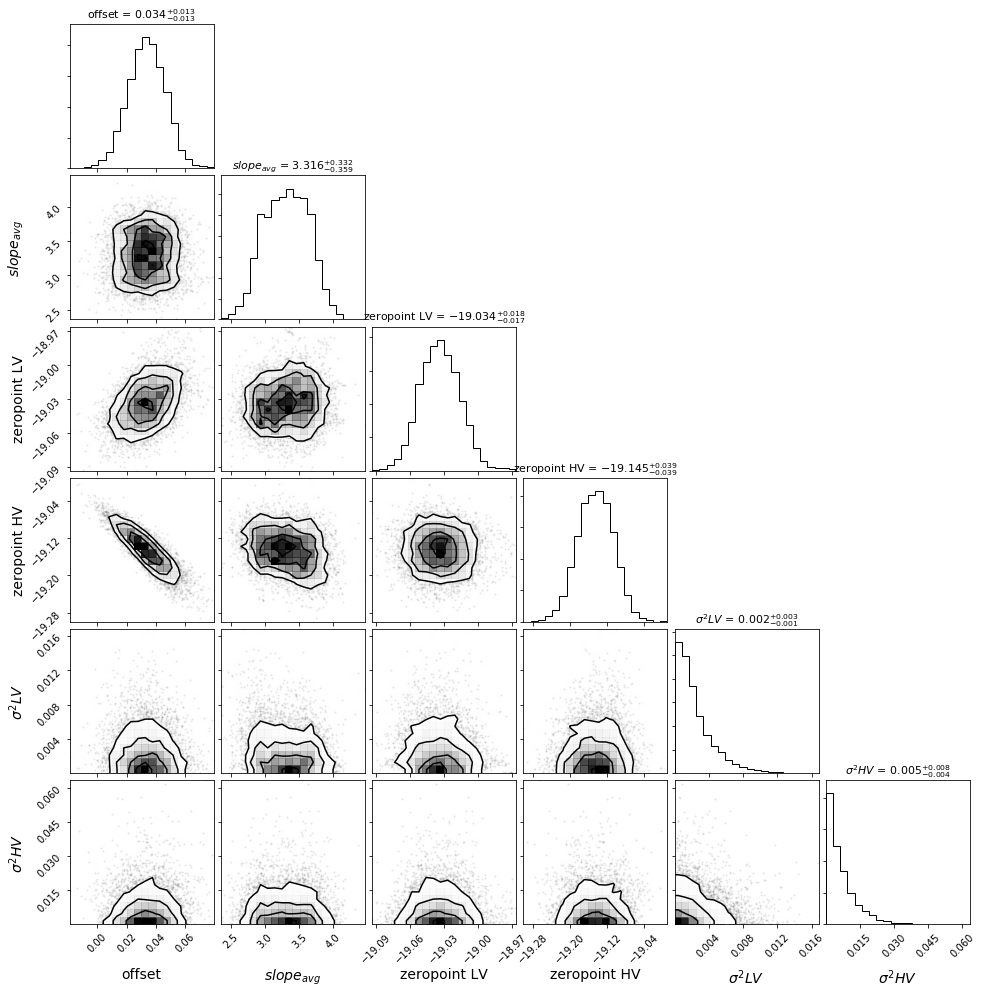

In [42]:
w09_uv_sep = dolinmix_sep(splitdata_w09suv,numiter=niter)
w09_cosmo_uv_sep = dolinmix_sep(splitdata_w09suv_cosmo,numiter=niter)
w09_ana_uv_sep = dolinmix_sep(splitdata_w09suv_ana,numiter=niter)

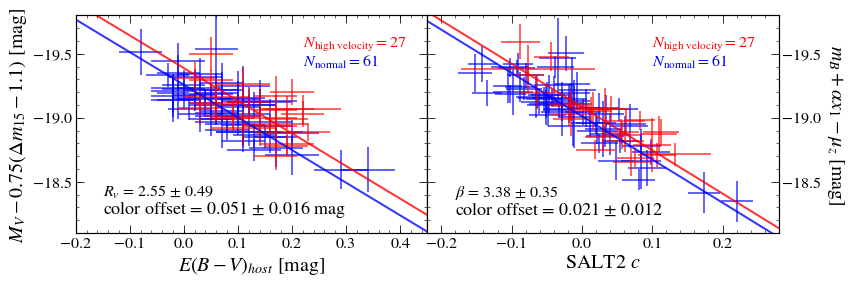

In [48]:
doublePlot_wfit(splitdata_w09s, splitdata_w09s_cosmo, w09_sep, w09_cosmo_sep)
plt.savefig('w09Comp_figures/comp_plot_cosmo.pdf',bbox_inches='tight')

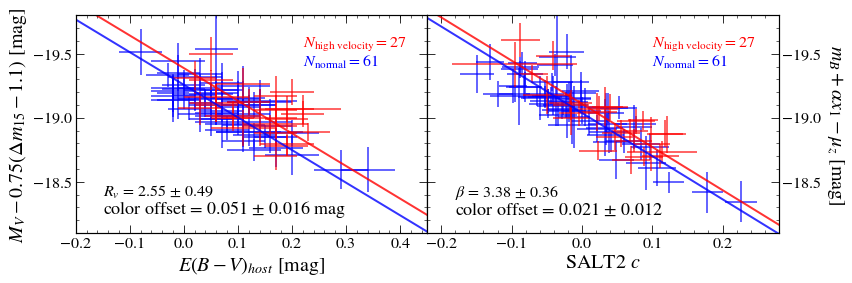

In [49]:
doublePlot_wfit(splitdata_w09s, splitdata_w09s_ana, w09_sep, w09_ana_sep)
plt.savefig('w09Comp_figures/comp_plot_ana.pdf',bbox_inches='tight')

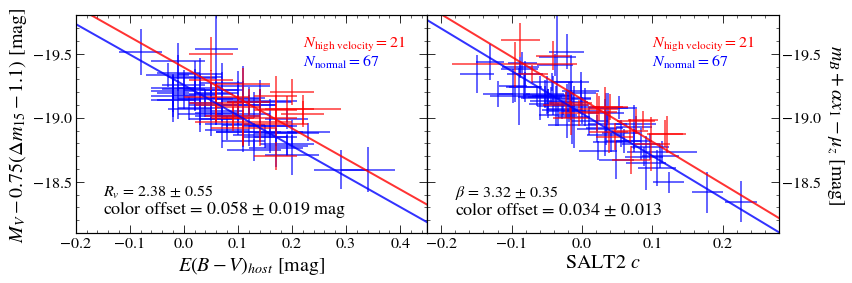

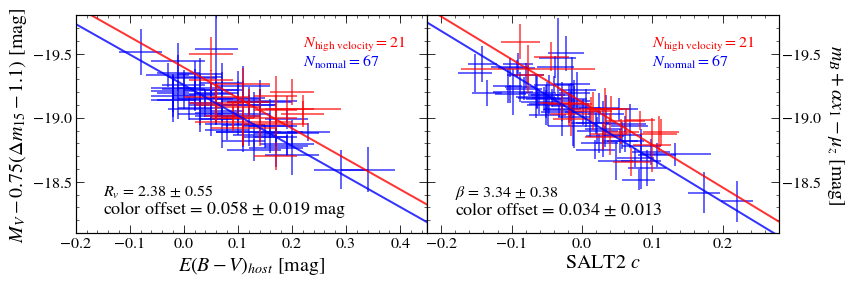

In [50]:
doublePlot_wfit(splitdata_w09suv, splitdata_w09suv_ana, w09_uv_sep, w09_ana_uv_sep)
plt.savefig('w09Comp_figures/comp_plot_ana_updated_vels.pdf',bbox_inches='tight')
doublePlot_wfit(splitdata_w09suv, splitdata_w09suv_cosmo, w09_uv_sep, w09_cosmo_uv_sep)
plt.savefig('w09Comp_figures/comp_plot_cosmo_updated_vels.pdf',bbox_inches='tight')

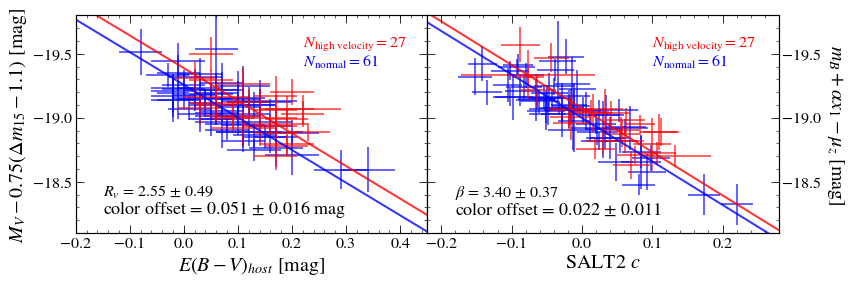

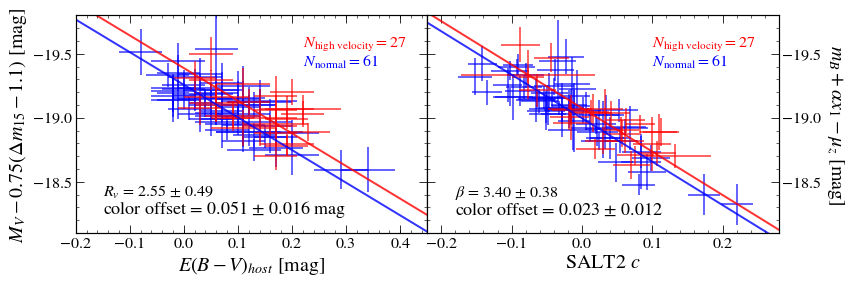

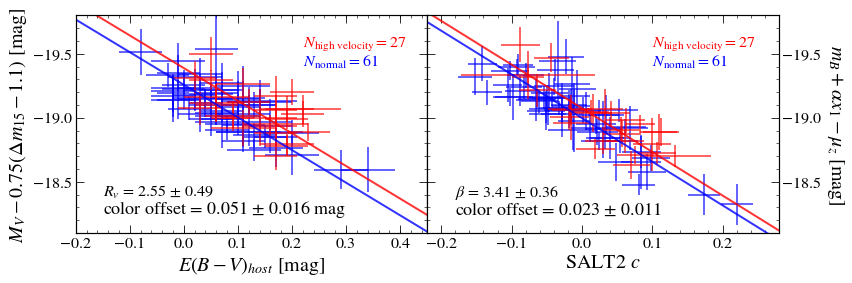

In [46]:
doublePlot_wfit(splitdata_w09s, splitdata_w09s_cosmo_a12, w09_sep, w09_cosmo_sep_a12)
doublePlot_wfit(splitdata_w09s, splitdata_w09s_cosmo_a16, w09_sep, w09_cosmo_sep_a16)
doublePlot_wfit(splitdata_w09s, splitdata_w09s_cosmo_a10, w09_sep, w09_cosmo_sep_a10)

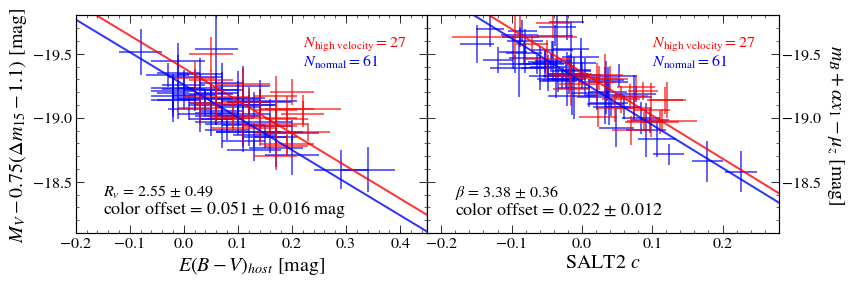

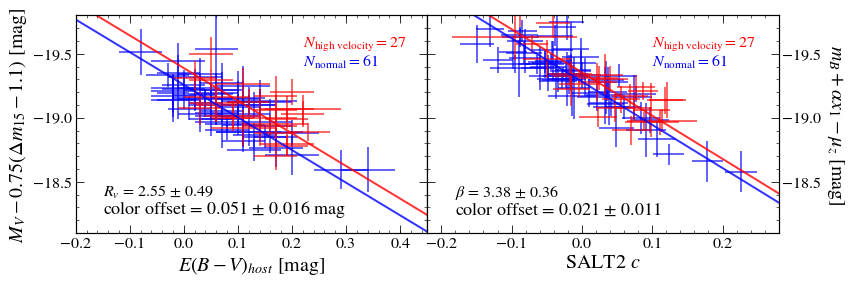

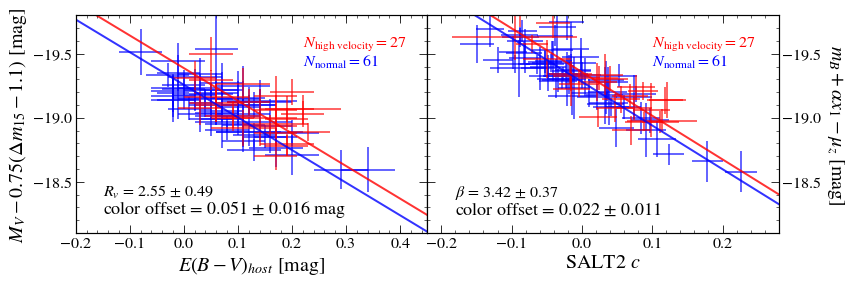

In [47]:
doublePlot_wfit(splitdata_w09s, splitdata_w09s_ana_a12, w09_sep, w09_ana_sep_a12)
doublePlot_wfit(splitdata_w09s, splitdata_w09s_ana_a16, w09_sep, w09_ana_sep_a16)
doublePlot_wfit(splitdata_w09s, splitdata_w09s_ana_a10, w09_sep, w09_ana_sep_a10)